# Unsupervised image denoising

## Import libraries

In [1]:
import torch 
from os import listdir
from os.path import join 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from sklearn import svm
from tqdm.notebook import tqdm
import os
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import matplotlib.patches as patches
import math
import time


## Load data

In [2]:
directory_data  = './'
image_input_data   = 'image_input.jpg'
image_target_data   = ['image_target1.jpg','image_target2.jpg','image_target3.jpg']
image_input      = img.imread(os.path.join(directory_data, image_input_data))
image_target = []
for image_url in image_target_data:
  image = img.imread(os.path.join(directory_data,image_url))
  image_target.append(image)



## Compute Derivative First Order, 미분을 이용해서 윤곽 정보만 땀

In [3]:
def compute_derivative_first_order(data, axis): 

    D = np.pad(data,(1,1), mode = 'edge')   # use numpy.pad function 
    if axis == 'x':
      derivative = np.roll(D,1)-D   # use numpy.roll function
        
    elif axis == 'y':
      derivative = np.roll(D,1,axis=0) -D# use numpy.roll function
        
    dD = derivative[1:data.shape[0]+1,1:data.shape[1]+1]   # remove the first and the last rows and columns for the boundary condition

    return(dD)

In [4]:
def gray_scale_derivative(image):
  if len(image.shape) == 3:
    image = image.mean(2)
  dx = compute_derivative_first_order(image,'x')
  dy = compute_derivative_first_order(image,'y')
  gradient_mag = np.sqrt(np.power(dx,2) + np.power(dy,2) )
  return gradient_mag

In [5]:

def image_rotate(image, degree):
    '''
    이미지를 degree만큼 회전시키는 함수
    회전된 이미지의 사이즈는 원본 이미지와 같음
    '''
    # degree를 라디안으로 바꿈
    rads = math.radians(degree)

    # 아웃풋 이미지를 원본 이미지와 동일하게 설정
    rot_img = np.zeros(image.shape)

    # 회전 축을 찾음
    height = rot_img.shape[0]
    width  = rot_img.shape[1]

    midx,midy = (width//2, height//2)

    for i in range(rot_img.shape[0]):
        for j in range(rot_img.shape[1]):
            x= (i-midx)*math.cos(rads)+(j-midy)*math.sin(rads)
            y= -(i-midx)*math.sin(rads)+(j-midy)*math.cos(rads)

            x=round(x)+midx 
            y=round(y)+midy 

            if (x>=0 and y>=0 and x<image.shape[0] and  y<image.shape[1]):
                rot_img[i,j] = image[x,y]

    return rot_img 

In [6]:

image_input_gray = torch.from_numpy(gray_scale_derivative(image_input))
image_target_gray = []
for image in image_target:
  out = torch.from_numpy( gray_scale_derivative(image))
  image_target_gray.append(out)
image_target_rotate45 = []

for image in image_target:
  out = torch.from_numpy( image_rotate(gray_scale_derivative(image),45))
  image_target_rotate45.append(out)
image_target_scaled = []

image_input_scale = image_input_gray[::2,::2]
for image in image_target:
  out = torch.from_numpy( image_rotate(gray_scale_derivative(image[::2,::2]),45))
  image_target_scaled.append(out)

In [7]:
def window_corr(input, window, h ,w,window_mean, window_std, stride=1, degree = 0):
 
  window_h, window_w = window.shape     
  h_start = h*stride # 시작지점에 stride 적용
  h_end = h_start + window_h 
  w_start  = w*stride # 시작지점에 stride 적용
  w_end = w_start + window_w
  target = input[h_start:h_end, w_start:w_end]
  if degree != 0:
    target = torch.from_numpy(image_rotate(target , degree))
  target_std = target.std()
  target_mean = target.mean()
  result = ((target - target_mean) *(window-window_mean)).mean()/(target_std*window_std)
  return result

In [8]:
 
def cross_correlation(image, window, stride=1, pad=0):
  h, w = image.shape

  window_h, window_w = window.shape

  window_std = window.std()
  window_mean = window.mean()
  out_h = int((h+2*pad-window_h)/stride +1)
  out_w = int((w+2*pad-window_w)/stride +1)
  input = torch.nn.functional.pad(input=image, pad=(pad,pad,pad,pad), mode='constant', value = 0)
  # add padding to height and width. 
  #  # padding으로 모양이 커진 in_X
  # print(n, n_f, out_h, out_w)
  out = torch.zeros((out_h, out_w))
  for h in range(out_h): 
    for w in range(out_w):
 
      out[h, w] = window_corr(input, window, h, w , window_mean= window_mean, window_std= window_std,stride= stride)
 
  return out

In [9]:

def cross_correlation_v2_rotate(image, window, stride=1, pad=0):
  h, w = image.shape

  window_h, window_w = window.shape

  window_std = window.std()
  window_mean = window.mean()
  out_h = int((h+2*pad-window_h)/stride +1)
  out_w = int((w+2*pad-window_w)/stride +1)
  input = torch.nn.functional.pad(input=image, pad=(pad,pad,pad,pad), mode='constant', value = 0)
  arr = []
  out = torch.zeros((out_h, out_w))
  for h in range(out_h): 
    for w in range(out_w):  
      arr = [] 
      ret0 = window_corr(input, window, h, w , window_mean= window_mean, window_std= window_std,stride= stride,degree=45)
      arr.append(ret0)
      ret1 = window_corr(input, window, h, w , window_mean= window_mean, window_std= window_std,stride= stride)
      arr.append(ret1)
      out[h,w] = max(arr) 

  return out

## Cross Correlation을 이용한 output

In [10]:
num_target_row = image_target_gray[0].shape[0]
num_target_col = image_target_gray[0].shape[1]
num_scaled_target_row = image_target_scaled[2].shape[0]
num_scaled_target_col = image_target_scaled[2].shape[1]


padding = num_target_col // 2
scaled_padding = num_scaled_target_col // 2
# print(padding)
naive_start = time.time()
naive_out = cross_correlation(image = image_input_gray,window = image_target_gray[0],stride = 1, pad = padding)
naive_time = naive_start - time.time()
rotate_start = time.time()
rotate_out = cross_correlation_v2_rotate(image = image_input_gray,window = image_target_rotate45[1],stride = 1, pad = padding)
rotate_time = rotate_start - time.time()

scaled_start = time.time()
scaled_rotate_out = cross_correlation_v2_rotate(image = image_input_scale,window = image_target_scaled[2],stride = 1, pad = scaled_padding)
scaled_time = scaled_start - time.time()

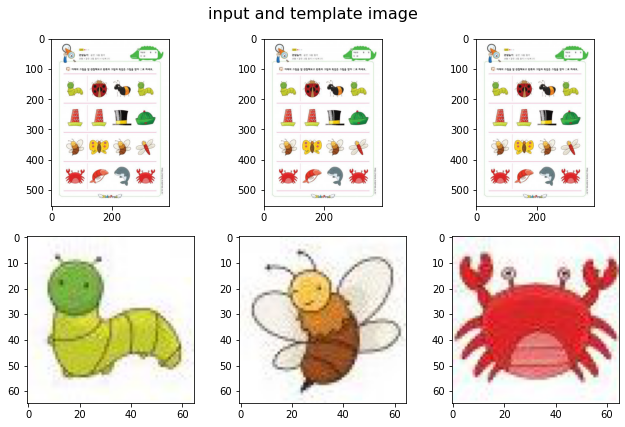

In [31]:
def show_input_template():
  nRow = 2
  nCol = 3
  size =3
  title = 'input and template image'

  fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
  fig.suptitle(title, fontsize=16)
  for c in range(nCol):
    axes[0,c].imshow(image_input) 
    axes[1,c].imshow(image_target[c]) 
  plt.tight_layout()
  plt.show()
show_input_template()

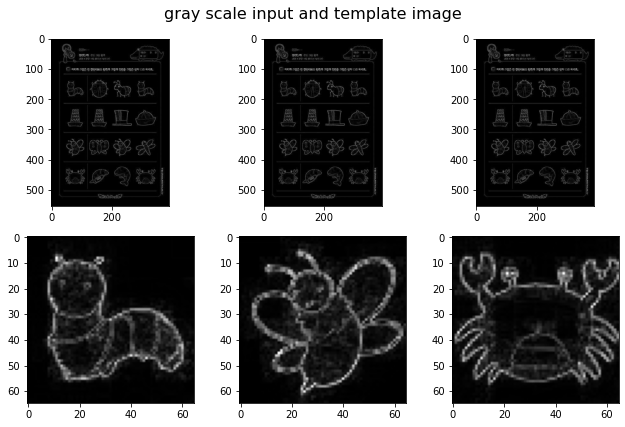

In [12]:
def show_input_template_gray_scale():
  nRow = 2
  nCol = 3
  size =3
  title = 'gray scale input and template image'

  fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
  fig.suptitle(title, fontsize=16)
  for c in range(nCol):
    axes[0,c].imshow(image_input_gray,cmap = 'gray') 
    axes[1,c].imshow(image_target_gray[c],cmap = 'gray') 
  plt.tight_layout()
  plt.show()

show_input_template_gray_scale()

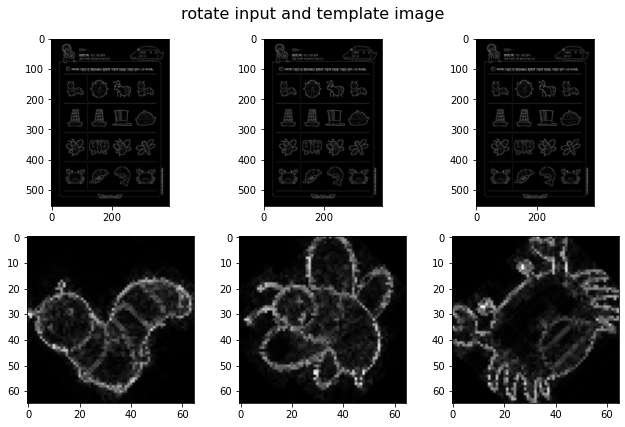

In [13]:
def show_input_template_rotate():
  nRow = 2
  nCol = 3
  size =3
  title = 'rotate input and template image'

  fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
  fig.suptitle(title, fontsize=16)
  for c in range(nCol):
    axes[0,c].imshow(image_input_gray,cmap = 'gray') 
    axes[1,c].imshow(image_target_rotate45[c],cmap = 'gray') 
  plt.tight_layout()
  plt.show()
  
show_input_template_rotate()

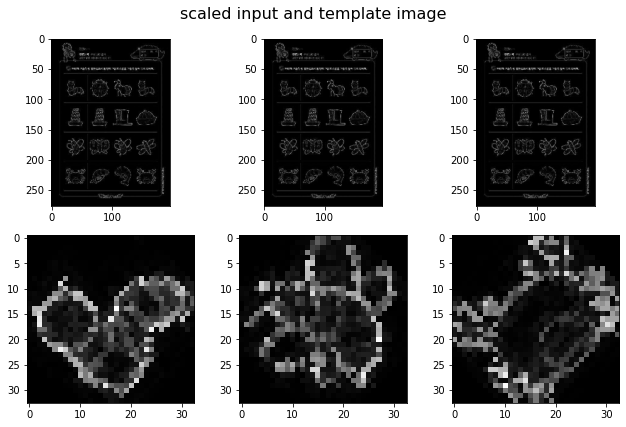

In [14]:
def show_input_template_scale():
  nRow = 2
  nCol = 3
  size =3
  title = 'scaled input and template image'

  fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
  fig.suptitle(title, fontsize=16)
  for c in range(nCol):
    axes[0,c].imshow(image_input_scale,cmap = 'gray') 
    axes[1,c].imshow(image_target_scaled[c],cmap = 'gray') 
  plt.tight_layout()
  plt.show()
  
show_input_template_scale()

maximum value of naive NCC is f0.9594899415969849
경과 시간 naive NCC is 18.587347984313965
maximum value of rotate NCC is f0.9708611965179443
경과 시간 rotate NCC is 5092.82775592804
maximum value of scaled NCC is 0.7372392416000366
경과 시간 scaled rotate NCC is 445.22371196746826


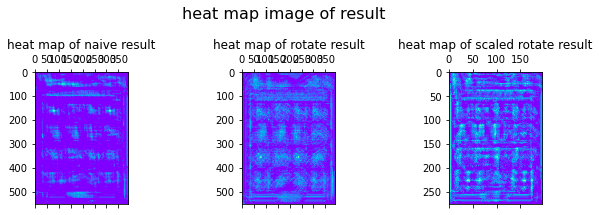

In [29]:
def show_result_of_NCC():
  print(f'maximum value of naive NCC is f{naive_out.max()}')
  print(f'경과 시간 naive NCC is {-naive_time}')
  print(f'maximum value of rotate NCC is f{rotate_out.max()}')
  print(f'경과 시간 rotate NCC is {-rotate_time}')

  print(f'maximum value of scaled NCC is {scaled_rotate_out.max()}')
  print(f'경과 시간 scaled rotate NCC is {-scaled_time}')
  nRow = 1
  nCol = 3
  size =3
  title = 'heat map image of result'
  
  fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
  fig.suptitle(title, fontsize=16)
  axes[0].matshow(naive_out,cmap = 'rainbow',vmin = 0 , vmax = 0.7)
  axes[0].set_title('heat map of naive result')
  axes[1].matshow(rotate_out,cmap = 'rainbow',vmin = 0 , vmax = 0.7)
  axes[1].set_title('heat map of rotate result')
  axes[2].matshow(scaled_rotate_out,cmap = 'rainbow',vmin = 0 , vmax = 0.7)
  axes[2].set_title('heat map of scaled rotate result')
  plt.tight_layout()
  plt.show()
  
show_result_of_NCC()

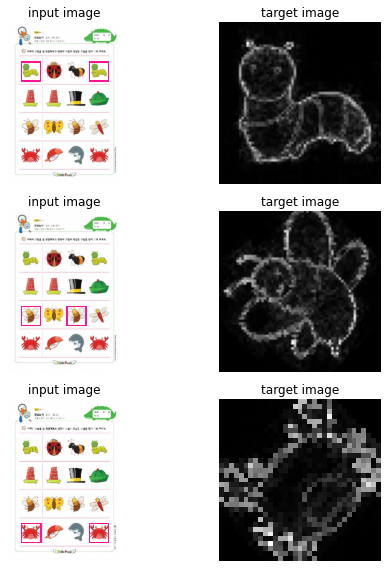

In [30]:
def show_bounding_box_of_NCC():
  other = torch.zeros(naive_out.shape)
  indices = torch.ones(naive_out.shape)
  result = torch.where(naive_out > 0.5,indices,other) 
  naive_indices = result.nonzero()
  
  other = torch.zeros(rotate_out.shape)
  indices = torch.ones(rotate_out.shape)
  result = torch.where(rotate_out > 0.5,indices,other) 
  rotate_indices = result.nonzero()
  
  other = torch.zeros(scaled_rotate_out.shape)
  indices = torch.ones(scaled_rotate_out.shape)
  result = torch.where(scaled_rotate_out > 0.5,indices,other) 
  scaled_indices = result.nonzero()
  
  
  plt.figure(figsize=(8,8))
  plt.subplot(321)
  plt.imshow(image_input , cmap = 'gray')
  for x,y in naive_indices:
    plt.gca().add_patch(patches.Rectangle((y -padding ,x-padding),width = num_target_row,height = num_target_col,edgecolor = 'deeppink',facecolor='lightgray',fill = False,))
  plt.title('input image')
  plt.axis('off')
  plt.subplot(322)
  plt.imshow(image_target_gray[0] , cmap = 'gray')
  plt.title('target image')
  plt.axis('off')

  plt.subplot(323)
  plt.imshow(image_input , cmap = 'gray')
  for x,y in rotate_indices:
    plt.gca().add_patch(patches.Rectangle((y -padding ,x-padding),width = num_target_row,height = num_target_col,edgecolor = 'deeppink',facecolor='lightgray',fill = False,))
  plt.title('input image')
  plt.axis('off')
  plt.subplot(324)
  plt.imshow(image_target_rotate45[1] , cmap = 'gray')
  plt.title('target image')
  plt.axis('off')

  plt.subplot(325)
  plt.imshow(image_input[::2,::2] , cmap = 'gray')
  for x,y in scaled_indices:
    plt.gca().add_patch(patches.Rectangle((y -scaled_padding ,x-scaled_padding),width = num_scaled_target_row,height = num_scaled_target_col,edgecolor = 'deeppink',facecolor='lightgray',fill = False,))
  plt.title('input image')
  plt.axis('off')
  plt.subplot(326)
  plt.imshow(image_target_scaled[2] , cmap = 'gray')
  plt.title('target image')
  plt.axis('off')
  plt.tight_layout()
  plt.show()

show_bounding_box_of_NCC()